In [4]:
import os
import math
import numpy as np
import pandas as pd
import calendar
import re
import matplotlib.pyplot as plt



In [5]:
data = pd.read_csv("data/train_2.csv").fillna(0)

In [10]:
def get_info(page):
    index = page.rfind('_')
    agent = page[index+1:]
    page = page[:index]

    index = page.rfind('_')
    whart = page[index+1:]
    page = page[:index]

    index = page.rfind('_')
    link = page[index+1:]
    keywords = page[:index]
    return keywords, link, whart, agent

def get_keyword(page):
    return get_info(page)[0]
def get_link(page):
    return get_info(page)[1]
def get_access(page):
    return get_info(page)[2]
def get_agent(page):
    return get_info(page)[3]




In [11]:
# data['link'] = data.Page.map(get_link)
# data['access'] = data.Page.map(get_access)
# data['agent'] = data.Page.map(get_agent)

In [12]:
page_details = data.Page.str.extract(r'(?P<topic>.*)\_(?P<lang>.*).wikipedia.org\_(?P<access>.*)\_(?P<agent>.*)')

/Users/fredxue/anaconda2/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
  """Entry point for launching an IPython kernel.


In [13]:
unique_topic = page_details['lang'].unique()

unique_topic

array(['zh', 'fr', 'en', nan, 'ru', 'de', 'ja', 'es'], dtype=object)

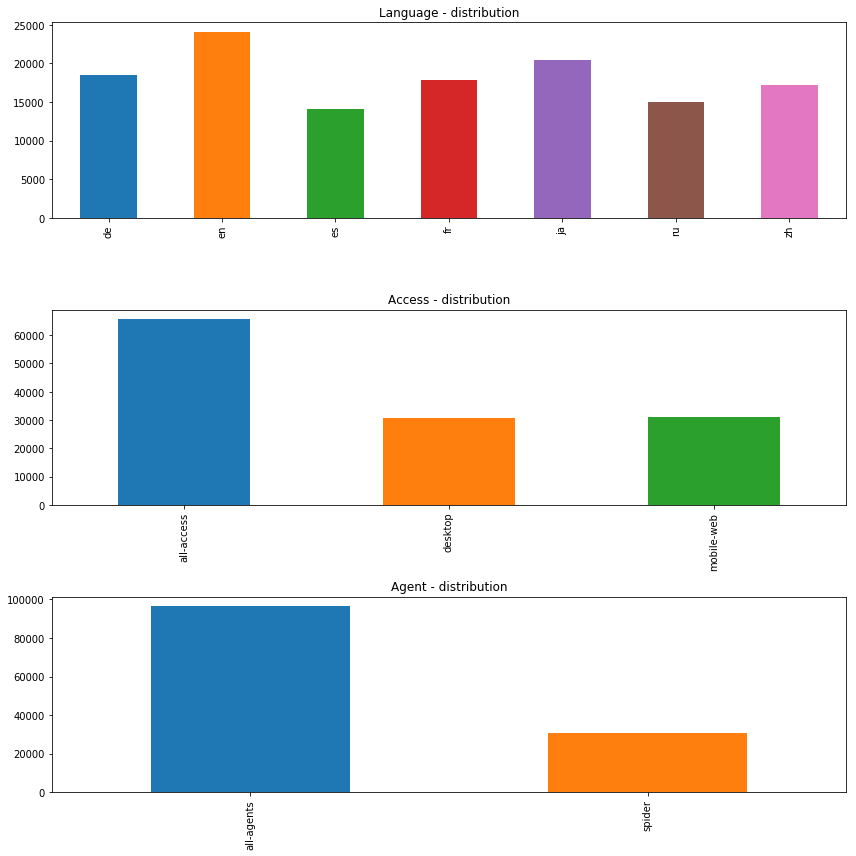

In [14]:
fig, axs  = plt.subplots(3,1,figsize=(12,12))

page_details["lang"].value_counts().sort_index().plot.bar(ax=axs[0])
axs[0].set_title('Language - distribution')

page_details["access"].value_counts().sort_index().plot.bar(ax=axs[1])
axs[1].set_title('Access - distribution')

page_details["agent"].value_counts().sort_index().plot.bar(ax=axs[2])
axs[2].set_title('Agent - distribution')

plt.tight_layout()

## Split data to train and test

In [15]:
# Generate train and validate dataset
train_df = pd.concat([page_details, data], axis=1)

def get_train_validate_set(train_df):
    train_end = train_df.shape[1]-60
    train_ds = train_df.iloc[:, np.r_[0,1,2,3,4,5:train_end]]
    test_ds = train_df.iloc[:, np.r_[0,1,2,3,4,train_end:train_df.shape[1]]]
    
    return train_ds, test_ds

X_train, y_train = get_train_validate_set(train_df)

print("The training set sample:")
print(X_train[0:10])
print("The test set sample:")
print(y_train[0:10])

The training set sample:
              topic lang      access   agent  \
0              2NE1   zh  all-access  spider   
1               2PM   zh  all-access  spider   
2                3C   zh  all-access  spider   
3           4minute   zh  all-access  spider   
4  52_Hz_I_Love_You   zh  all-access  spider   
5              5566   zh  all-access  spider   
6            91Days   zh  all-access  spider   
7             A'N'D   zh  all-access  spider   
8             AKB48   zh  all-access  spider   
9             ASCII   zh  all-access  spider   

                                                Page  2015-07-01  2015-07-02  \
0            2NE1_zh.wikipedia.org_all-access_spider        18.0        11.0   
1             2PM_zh.wikipedia.org_all-access_spider        11.0        14.0   
2              3C_zh.wikipedia.org_all-access_spider         1.0         0.0   
3         4minute_zh.wikipedia.org_all-access_spider        35.0        13.0   
4  52_Hz_I_Love_You_zh.wikipedia.org_all-acces

## Evaluation SMAPE

In [38]:
def smape(predict, actual, debug=False):
    '''
    predict and actual is a panda series.
    In this implementation I will skip all the datapoint with actual is null
    '''
    
    actual = actual.fillna(0)
    data = pd.concat([predict, actual], axis=1, keys=['predict', 'actual'])
    data = data[data.actual.notnull()]
    if debug:
        print('debug', data)
    
    evals = abs(data.predict - data.actual) * 1.0 / (abs(data.predict) + abs(data.actual)) * 2
    evals[evals.isnull()] = 0
    #print(np.sum(evals), len(data), np.sum(evals) * 1.0 / len(data))
    
    result = np.sum(evals) / len(data)
    
    return result

# create testing series
testing_series_1 = X_train.iloc[0, 5:494]
testing_series_2 = X_train.iloc[0, 5:494].shift(-1)
testing_series_3 = X_train.iloc[1, 5:494]
testing_series_4 = pd.Series([0,0,0,0])

## Median Model

In [39]:
def plot_prediction_and_actual_2(train, forecast, actual, xlim=None, ylim=None, figSize=None, title=None):
    fig, ax  = plt.subplots(1,1,figsize=figSize)
    ax.plot(pd.to_datetime(train.index), train.values, 'k.')
    ax.plot(pd.to_datetime(actual.index), actual.values, 'r.')
    ax.plot(pd.to_datetime(forecast.index), forecast.values, 'b-')
    ax.set_title(title)
    plt.show()

In [42]:
def median_model(df_train, df_actual, p, review=False, figSize=(12, 4)):
    
    def nanmedian_zero(a):
        return np.nan_to_num(np.nanmedian(a))
    
    df_train['y'] = df_train['y'].convert_objects(convert_numeric=True)
    df_actual['y'] = df_actual['y'].convert_objects(convert_numeric=True)
    visits = nanmedian_zero(df_train['y'].values[-p:])
    train_series = df_train['y']
    train_series.index = df_train.ds
    
    idx = np.arange( p) + np.arange(len(df_train)- p+1)[:,None]
    b = [row[row>=0] for row in df_train.y.values[idx]]
    pre_forecast = pd.Series(np.append(([float('nan')] * (p-1)), list(map(nanmedian_zero,b))))
    pre_forecast.index = df_train.ds
    
    forecast_series = pd.Series(np.repeat(visits, len(df_actual)))
    forecast_series.index = df_actual.ds
    
    forecast_series = pre_forecast.append(forecast_series)
    
    actual_series = df_actual.y
    actual_series.index = df_actual.ds
    
    if(review):
        plot_prediction_and_actual_2(train_series, forecast_series, actual_series, figSize=figSize, title='Median model')
    
    return smape(forecast_series, actual_series, debug = True)

In [47]:
def extract_series(df, row_num, start_idx):
    y = df.iloc[row_num, start_idx:]
    df = pd.DataFrame({ 'ds': y.index, 'y': y.values})
    return df

                                    Page  2015-07-01  2015-07-02  2015-07-03  \
2  3C_zh.wikipedia.org_all-access_spider         1.0         0.0         1.0   

   2015-07-04  2015-07-05  2015-07-06  2015-07-07  2015-07-08  2015-07-09  \
2         1.0         0.0         4.0         0.0         3.0         4.0   

      ...      2017-09-01  2017-09-02  2017-09-03  2017-09-04  2017-09-05  \
2     ...             6.0         6.0         7.0         2.0         4.0   

   2017-09-06  2017-09-07  2017-09-08  2017-09-09  2017-09-10  
2         7.0         3.0         4.0         7.0         6.0  

[1 rows x 804 columns]
2015-07-01     1
2015-07-02     0
2015-07-03     1
2015-07-04     1
2015-07-05     0
2015-07-06     4
2015-07-07     0
2015-07-08     3
2015-07-09     4
2015-07-10     4
2015-07-11     1
2015-07-12     1
2015-07-13     1
2015-07-14     6
2015-07-15     8
2015-07-16     6
2015-07-17     4
2015-07-18     5
2015-07-19     1
2015-07-20     2
2015-07-21     3
2015-07-22     8
201

/Users/fredxue/anaconda2/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use Series.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  
/Users/fredxue/anaconda2/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:7: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use Series.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  import sys


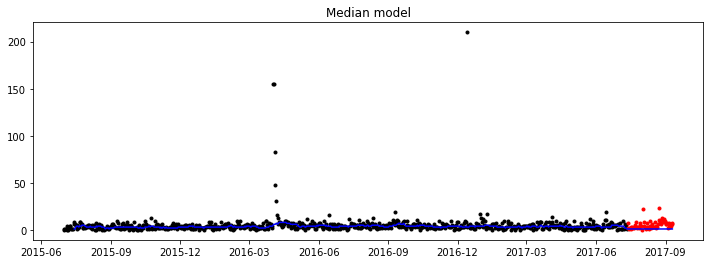

debug             predict  actual
2017-07-13      1.0     7.0
2017-07-14      1.0     2.0
2017-07-15      1.0     1.0
2017-07-16      1.0     2.0
2017-07-17      1.0     3.0
2017-07-18      1.0     1.0
2017-07-19      1.0     3.0
2017-07-20      1.0     2.0
2017-07-21      1.0     2.0
2017-07-22      1.0     3.0
2017-07-23      1.0     5.0
2017-07-24      1.0     8.0
2017-07-25      1.0     2.0
2017-07-26      1.0     3.0
2017-07-27      1.0     3.0
2017-07-28      1.0     2.0
2017-07-29      1.0     5.0
2017-07-30      1.0     7.0
2017-07-31      1.0     4.0
2017-08-01      1.0     0.0
2017-08-02      1.0    22.0
2017-08-03      1.0     8.0
2017-08-04      1.0     4.0
2017-08-05      1.0     3.0
2017-08-06      1.0     1.0
2017-08-07      1.0     3.0
2017-08-08      1.0     7.0
2017-08-09      1.0     3.0
2017-08-10      1.0     1.0
2017-08-11      1.0     9.0
2017-08-12      1.0     4.0
2017-08-13      1.0     2.0
2017-08-14      1.0     6.0
2017-08-15      1.0     3.0
2017-08-16    

In [48]:
# This is to demo the median model
print(data.iloc[[2]])

df_train = extract_series(X_train, 2, 5)
df_actual = extract_series(y_train, 2, 5)

score = median_model(df_train.copy(), df_actual.copy(), 15, review=True)
print("The SMAPE score is : %.5f" % score)

## FB Prophet

In [21]:
from fbprophet import Prophet

In [22]:
def plot_prediction_and_actual(model, forecast, actual, xlim=None, ylim=None, figSize=None, title=None):
    fig, ax  = plt.subplots(1,1,figsize=figSize)
    ax.set_ylim(ylim)
    ax.plot(pd.to_datetime(actual.ds), actual.y, 'r.')
    model.plot(forecast, ax=ax);
    ax.set_title(title)
    plt.show()

In [23]:
# simple linear model
def normal_model(df_train, df_actual, review=False):
    start_date = df_actual.ds.min()
    end_date = df_actual.ds.max()
    
    actual_series = df_actual.y.copy()
    actual_series.index = df_actual.ds

    df_train['y'] = df_train['y'].astype('float')
    
    df_actual['y'] = df_actual['y'].astype('float')
    
    m = Prophet()
    m.fit(df_train)
    future = m.make_future_dataframe(periods=60)
    forecast = m.predict(future)
        
    if(review):
        ymin = min(df_actual.y.min(), df_train.y.min()) -100
        ymax = max(df_actual.y.max(), df_train.y.max()) +100
        #
        plot_prediction_and_actual(m, forecast, df_actual, ylim=[ymin, ymax], figSize=(12,4), title='Normal model')
    
    mask = (forecast['ds'] >= start_date) & (forecast['ds'] <= end_date)
    forecast_series = forecast[mask].yhat
    forecast_series.index = forecast[mask].ds
    forecast_series[forecast_series < 0] = 0

    return smape(forecast_series, actual_series)

In [24]:
# log model
def normal_model_log(df_train, df_actual, review=False):
    start_date = df_actual.ds.min()
    end_date = df_actual.ds.max()
    
    actual_series = df_actual.y.copy()
    actual_series.index = df_actual.ds

    df_train['y'] = df_train['y'].astype('float')
    df_train.y = np.log1p(df_train.y)
    
    df_actual['y'] = df_actual['y'].astype('float')
    df_actual.y = np.log1p(df_actual.y)
    
    m = Prophet()
    m.fit(df_train)
    future = m.make_future_dataframe(periods=60)
    forecast = m.predict(future)
    
    if(review):
        ymin = min(df_actual.y.min(), df_train.y.min()) -2
        ymax = max(df_actual.y.max(), df_train.y.max()) +2
        plot_prediction_and_actual(m, forecast, df_actual, ylim=[ymin, ymax], figSize=(12,4), title='Normal model in log')
        
    mask = (forecast['ds'] >= start_date) & (forecast['ds'] <= end_date)
    forecast_series = np.expm1(forecast[mask].yhat)
    forecast_series.index = forecast[mask].ds
    forecast_series[forecast_series < 0] = 0

    return smape(forecast_series, actual_series)

INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


                                    Page  2015-07-01  2015-07-02  2015-07-03  \
2  3C_zh.wikipedia.org_all-access_spider         1.0         0.0         1.0   

   2015-07-04  2015-07-05  2015-07-06  2015-07-07  2015-07-08  2015-07-09  \
2         1.0         0.0         4.0         0.0         3.0         4.0   

      ...      2017-09-01  2017-09-02  2017-09-03  2017-09-04  2017-09-05  \
2     ...             6.0         6.0         7.0         2.0         4.0   

   2017-09-06  2017-09-07  2017-09-08  2017-09-09  2017-09-10  
2         7.0         3.0         4.0         7.0         6.0  

[1 rows x 804 columns]


/Users/fredxue/anaconda2/envs/py3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


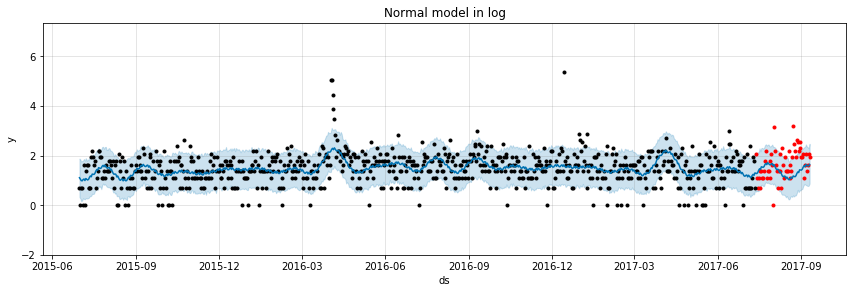

The SMAPE score is : 0.64472


In [27]:
print(data.iloc[[2]])

df_train = extract_series(X_train, 2, 5)
df_actual = extract_series(y_train, 2, 5)
lang = X_train.iloc[2, 1]
score = normal_model_log(df_train.copy(), df_actual.copy(), review=True)
print("The SMAPE score is : %.5f" % score)